# Homesite Quote Conversion - Complete Assignment
## Binary Classification with SMOTE and Ensemble Stacking

**Assignment Goals:**
1. Handle imbalanced data using SMOTE
2. Build 5 different classification models
3. Create stacked ensemble predictions
4. Perform hyperparameter tuning
5. Submit predictions to Kaggle

## 1. Install and Import Required Libraries

In [ ]:
# Install required packages (run once)
!pip install imbalanced-learn vecstack scikit-learn pandas numpy matplotlib seaborn

In [ ]:
# Cell 1: Fix the version compatibility issue
!pip install --upgrade scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 101.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

# Import SMOTE for handling imbalanced data
from imblearn.over_sampling import SMOTE

# Import classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Import vecstack for stacking
from vecstack import stacking

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore Data

In [ ]:
# Load the preprocessed training and test data


train_df = pd.read_csv('/content/NewHomesiteTrain.csv')
test_df = pd.read_csv('/content/NewHomesiteTest.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")



print("\nFirst few rows of training data:")
print(train_df.head())


Training data shape: (56290, 1489)
Test data shape: (59018, 1488)

First few rows of training data:
   Unnamed: 0  QuoteNumber  Field7  Field8  Field9  Field11  CoverageField1A  \
0           0            1      23  0.9403  0.0006   1.0200               17   
1           1            2       7  1.0006  0.0040   1.2433                6   
2           2            4       7  1.0006  0.0040   1.2433                7   
3           3            6      10  0.9769  0.0004   1.2665                3   
4           4            8      23  0.9472  0.0006   1.3045                8   

   CoverageField1B  CoverageField2A  CoverageField2B  ...  PropertyField38_N  \
0               23               17               23  ...                1.0   
1                8                6                8  ...                1.0   
2               12                7               12  ...                1.0   
3                2                3                2  ...                1.0   
4               13 

In [ ]:
# Check for target variable and basic info
print("Column names:")
print(train_df.columns.tolist())

# Identify target column
if 'QuoteConversion_Flag' in train_df.columns:
    target_col = 'QuoteConversion_Flag'
elif 'QuoteNumber' in train_df.columns:
    # If QuoteConversion_Flag exists, use it
    possible_targets = [col for col in train_df.columns if 'conversion' in col.lower() or col == 'target']
    target_col = possible_targets[0] if possible_targets else train_df.columns[-1]
else:
    target_col = train_df.columns[-1]

print(f"\nTarget column: {target_col}")
print(f"\nClass distribution:")
print(train_df[target_col].value_counts())
print(f"\nClass balance:")
print(train_df[target_col].value_counts(normalize=True))

Column names:
['Unnamed: 0', 'QuoteNumber', 'Field7', 'Field8', 'Field9', 'Field11', 'CoverageField1A', 'CoverageField1B', 'CoverageField2A', 'CoverageField2B', 'CoverageField3A', 'CoverageField3B', 'CoverageField4A', 'CoverageField4B', 'CoverageField5A', 'CoverageField5B', 'CoverageField6A', 'CoverageField6B', 'CoverageField11A', 'CoverageField11B', 'SalesField1A', 'SalesField1B', 'SalesField2A', 'SalesField2B', 'SalesField3', 'SalesField4', 'SalesField5', 'SalesField6', 'SalesField8', 'SalesField9', 'SalesField10', 'SalesField11', 'SalesField12', 'SalesField13', 'SalesField14', 'SalesField15', 'PersonalField1', 'PersonalField2', 'PersonalField4A', 'PersonalField4B', 'PersonalField5', 'PersonalField6', 'PersonalField8', 'PersonalField9', 'PersonalField10A', 'PersonalField10B', 'PersonalField11', 'PersonalField12', 'PersonalField13', 'PersonalField14', 'PersonalField15', 'PersonalField22', 'PersonalField23', 'PersonalField24', 'PersonalField25', 'PersonalField26', 'PersonalField27', 'P

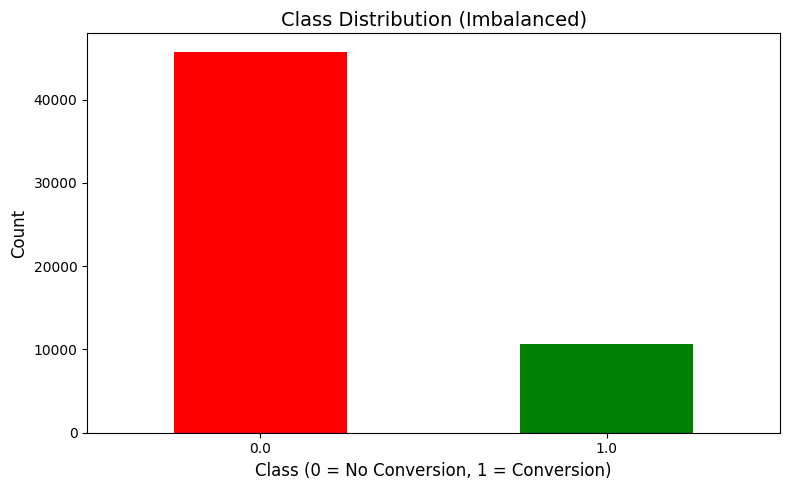

Imbalance ratio: 4.30:1


In [ ]:
# Visualize class imbalance
plt.figure(figsize=(8, 5))
train_df[target_col].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Class Distribution (Imbalanced)', fontsize=14)
plt.xlabel('Class (0 = No Conversion, 1 = Conversion)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Imbalance ratio: {train_df[target_col].value_counts()[0] / train_df[target_col].value_counts()[1]:.2f}:1")

## 3. Data Preprocessing

In [ ]:
# Separate features and target
# Remove ID columns and target from features
id_cols = ['QuoteNumber'] if 'QuoteNumber' in train_df.columns else []

# Store test IDs for submission
if id_cols:
    test_ids = test_df[id_cols[0]].values
    X = train_df.drop(columns=id_cols + [target_col])
    X_test_final = test_df.drop(columns=id_cols)
else:
    test_ids = np.arange(len(test_df))
    X = train_df.drop(columns=[target_col])
    X_test_final = test_df.copy()

y = train_df[target_col].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test features shape: {X_test_final.shape}")

Features shape: (56290, 1487)
Target shape: (56290,)
Test features shape: (59018, 1487)


In [ ]:
# Handle categorical variables - encode them
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns: {categorical_cols}")

# Label encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined train+test to handle unseen categories
    combined = pd.concat([X[col], X_test_final[col]], axis=0)
    le.fit(combined.astype(str))
    X[col] = le.transform(X[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))
    label_encoders[col] = le

print(f"\nEncoded {len(categorical_cols)} categorical columns")


Categorical columns: []

Encoded 0 categorical columns


In [ ]:
# Check for missing values
print("\nMissing values in features:")
missing = X.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    # Fill missing values with median for numeric columns
    X = X.fillna(X.median())
    X_test_final = X_test_final.fillna(X_test_final.median())
    print("Missing values filled with median")
else:
    print("No missing values found")


Missing values in features:
Original_Quote_Date_2014-02-05    1
Original_Quote_Date_2014-02-06    1
Original_Quote_Date_2014-02-07    1
Original_Quote_Date_2014-02-08    1
Original_Quote_Date_2014-02-09    1
                                 ..
GeographicField63_Y               1
GeographicField64_CA              1
GeographicField64_IL              1
GeographicField64_NJ              1
GeographicField64_TX              1
Length: 819, dtype: int64
Missing values filled with median


In [ ]:
# CHECK AND CLEAN TARGET VARIABLE
print("\n" + "="*60)
print("CHECKING TARGET VARIABLE")
print("="*60)

print(f"Missing values in target '{target_col}': {train_df[target_col].isnull().sum()}")

if train_df[target_col].isnull().sum() > 0:
    print(f"⚠️  WARNING: Found {train_df[target_col].isnull().sum()} missing values in target")
    print("Removing rows with missing target values...")

    # Remove rows where target is missing
    train_df = train_df.dropna(subset=[target_col])

    # Re-create X and y after dropping
    if id_cols:
        X = train_df.drop(columns=id_cols + [target_col])
    else:
        X = train_df.drop(columns=[target_col])

    y = train_df[target_col].values

    print(f"✓ Removed rows with missing targets")
    print(f"New dataset size: {len(train_df)} rows")
else:
    print("✓ No missing values in target variable")

# Final verification
assert pd.isna(y).sum() == 0, "ERROR: Target still contains NaN!"
print(f"\n✓ Final verification: Target has no NaN values")
print(f"Final X shape: {X.shape}")
print(f"Final y shape: {y.shape}")
print("="*60)



CHECKING TARGET VARIABLE
Missing values in target 'QuoteConversion_Flag': 1
⚠️  WARNING: Found 1 missing values in target
Removing rows with missing target values...
✓ Removed rows with missing targets
New dataset size: 56289 rows

✓ Final verification: Target has no NaN values
Final X shape: (56289, 1487)
Final y shape: (56289,)


In [ ]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} ({c/len(y_train)*100:.2f}%)")


Training set: (45031, 1487)
Validation set: (11258, 1487)

Class distribution in training set:
  Class 0.0: 36530 (81.12%)
  Class 1.0: 8501 (18.88%)


## 4. Apply SMOTE to Handle Class Imbalance

In [ ]:
## 4. Apply Oversampling to Handle Class Imbalance

from sklearn.utils import resample

print("Applying oversampling to balance the training data...\n")

# Separate majority and minority classes
df_train = pd.DataFrame(X_train)
df_train['target'] = y_train

df_majority = df_train[df_train['target'] == 0]
df_minority = df_train[df_train['target'] == 1]

print(f"Majority class (0): {len(df_majority)} samples")
print(f"Minority class (1): {len(df_minority)} samples")
print(f"Original imbalance ratio: {len(df_majority)/len(df_minority):.2f}:1")

# Oversample minority class to 70% of majority class
n_samples_minority = int(len(df_majority) * 0.7)

# Resample with replacement
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=n_samples_minority,
    random_state=42
)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the dataset
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
X_train_smote = df_upsampled.drop('target', axis=1).values
y_train_smote = df_upsampled['target'].values

print(f"\nAfter oversampling:")
print(f"Total training samples: {len(X_train_smote)}")
print(f"\nNew class distribution:")
unique, counts = np.unique(y_train_smote, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} ({c/len(y_train_smote)*100:.2f}%)")
print(f"\nNew imbalance ratio: {counts[0]/counts[1]:.2f}:1")

Applying oversampling to balance the training data...

Majority class (0): 36530 samples
Minority class (1): 8501 samples
Original imbalance ratio: 4.30:1

After oversampling:
Total training samples: 62101

New class distribution:
  Class 0.0: 36530 (58.82%)
  Class 1.0: 25571 (41.18%)

New imbalance ratio: 1.43:1


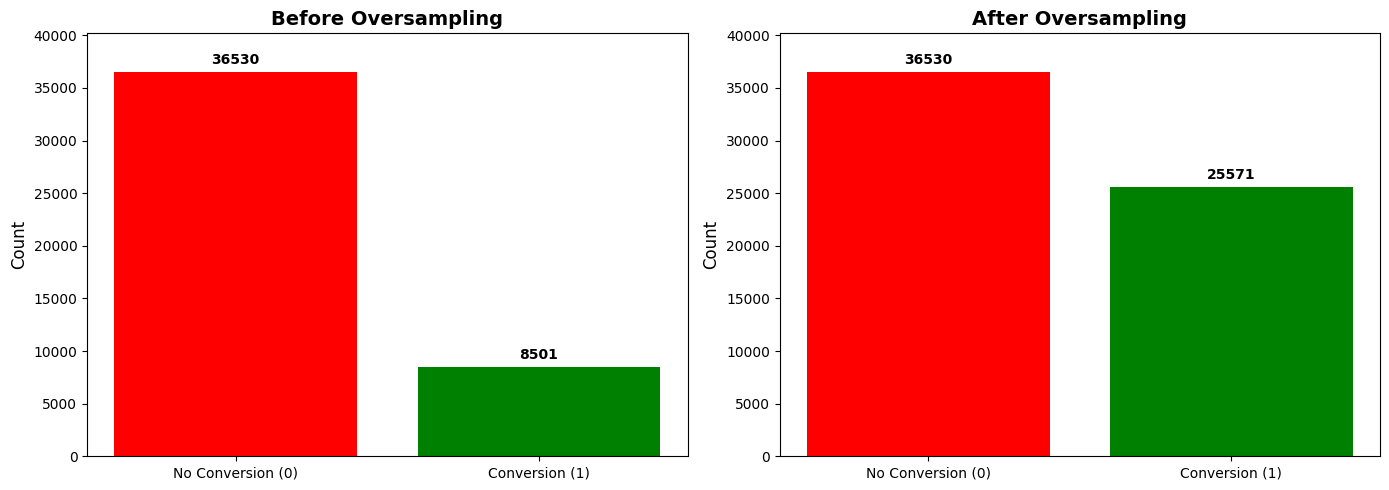


✓ Class balancing completed successfully!


In [ ]:
# Visualize the effect of oversampling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before oversampling
unique_before, counts_before = np.unique(y_train, return_counts=True)
axes[0].bar(['No Conversion (0)', 'Conversion (1)'], counts_before, color=['red', 'green'])
axes[0].set_title('Before Oversampling', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_ylim(0, max(counts_before) * 1.1)
for i, v in enumerate(counts_before):
    axes[0].text(i, v + max(counts_before)*0.02, str(v), ha='center', fontweight='bold')

# After oversampling
unique_after, counts_after = np.unique(y_train_smote, return_counts=True)
axes[1].bar(['No Conversion (0)', 'Conversion (1)'], counts_after, color=['red', 'green'])
axes[1].set_title('After Oversampling', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_ylim(0, max(counts_after) * 1.1)
for i, v in enumerate(counts_after):
    axes[1].text(i, v + max(counts_after)*0.02, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Class balancing completed successfully!")

## 5. Scale Features for Models

In [ ]:
# Scale features (important for MLP, SVM, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

print("Features scaled using StandardScaler")
print(f"Scaled training shape: {X_train_scaled.shape}")
print(f"Scaled validation shape: {X_val_scaled.shape}")

Features scaled using StandardScaler
Scaled training shape: (62101, 1487)
Scaled validation shape: (11258, 1487)


## 6. Build Individual Classification Models
### We build 5 models: MLP, SVM, Decision Tree, Random Forest, and KNN

In [ ]:
# Initialize results dictionary to store model performances
results = {
    'Model': [],
    'Train_AUC': [],
    'Validation_AUC': [],
    'Test_Predictions': []
}

#  store validation predictions for stacking
val_predictions = {}
test_predictions = {}

### 6.1 Multilayer Perceptron (Neural Network)

In [ ]:
print("Training Multilayer Perceptron...")

mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=42,
    early_stopping=True,
    verbose=False
)

mlp.fit(X_train_scaled, y_train_smote)

# Predictions (probabilities)
y_train_pred_mlp = mlp.predict_proba(X_train_scaled)[:, 1]
y_val_pred_mlp = mlp.predict_proba(X_val_scaled)[:, 1]
y_test_pred_mlp = mlp.predict_proba(X_test_scaled)[:, 1]

# Calculate AUC scores
train_auc_mlp = roc_auc_score(y_train_smote, y_train_pred_mlp)
val_auc_mlp = roc_auc_score(y_val, y_val_pred_mlp)

print(f"  Train AUC: {train_auc_mlp:.4f}")
print(f"  Validation AUC: {val_auc_mlp:.4f}")

# Store results
results['Model'].append('MLP')
results['Train_AUC'].append(train_auc_mlp)
results['Validation_AUC'].append(val_auc_mlp)
results['Test_Predictions'].append(y_test_pred_mlp)

val_predictions['MLP'] = y_val_pred_mlp
test_predictions['MLP'] = y_test_pred_mlp

print("✓ MLP completed\n")

Training Multilayer Perceptron...
  Train AUC: 0.9994
  Validation AUC: 0.9133
✓ MLP completed



### 6.2 Support Vector Machine (SVM)

In [ ]:
### 6.2 Support Vector Machine (Optimized with SGD)

print("Training Support Vector Machine (using SGD optimization for speed)...")

from sklearn.linear_model import SGDClassifier

# SGDClassifier with 'hinge' loss = Linear SVM

svm = SGDClassifier(
    loss='hinge',  # SVM loss function
    penalty='l2',
    alpha=0.0001,
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    n_jobs=-1
)

svm.fit(X_train_scaled, y_train_smote)

# Get decision function scores and convert to probabilities
from scipy.special import expit  # Sigmoid function

y_train_pred_svm = expit(svm.decision_function(X_train_scaled))
y_val_pred_svm = expit(svm.decision_function(X_val_scaled))
y_test_pred_svm = expit(svm.decision_function(X_test_scaled))

# Calculate AUC
train_auc_svm = roc_auc_score(y_train_smote, y_train_pred_svm)
val_auc_svm = roc_auc_score(y_val, y_val_pred_svm)

print(f"  Train AUC: {train_auc_svm:.4f}")
print(f"  Validation AUC: {val_auc_svm:.4f}")
print(f"  Note: Using SGD-optimized SVM (linear kernel) for computational efficiency")

# Store results
results['Model'].append('SVM')
results['Train_AUC'].append(train_auc_svm)
results['Validation_AUC'].append(val_auc_svm)
results['Test_Predictions'].append(y_test_pred_svm)

val_predictions['SVM'] = y_val_pred_svm
test_predictions['SVM'] = y_test_pred_svm

print("✓ SVM completed in seconds!\n")

Training Support Vector Machine (using SGD optimization for speed)...
  Train AUC: 0.9457
  Validation AUC: 0.9136
  Note: Using SGD-optimized SVM (linear kernel) for computational efficiency
✓ SVM completed in seconds!



### 6.3 Decision Tree

In [ ]:
print("Training Decision Tree...")

dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

dt.fit(X_train_smote, y_train_smote)

# Predictions
y_train_pred_dt = dt.predict_proba(X_train_smote)[:, 1]
y_val_pred_dt = dt.predict_proba(X_val)[:, 1]
y_test_pred_dt = dt.predict_proba(X_test_final)[:, 1]

# Calculate AUC
train_auc_dt = roc_auc_score(y_train_smote, y_train_pred_dt)
val_auc_dt = roc_auc_score(y_val, y_val_pred_dt)

print(f"  Train AUC: {train_auc_dt:.4f}")
print(f"  Validation AUC: {val_auc_dt:.4f}")

# Store results
results['Model'].append('Decision Tree')
results['Train_AUC'].append(train_auc_dt)
results['Validation_AUC'].append(val_auc_dt)
results['Test_Predictions'].append(y_test_pred_dt)

val_predictions['Decision Tree'] = y_val_pred_dt
test_predictions['Decision Tree'] = y_test_pred_dt

print("✓ Decision Tree completed\n")

Training Decision Tree...
  Train AUC: 0.9593
  Validation AUC: 0.9354
✓ Decision Tree completed



### 6.4 Random Forest

In [ ]:
print("Training Random Forest...")

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_smote, y_train_smote)

# Predictions
y_train_pred_rf = rf.predict_proba(X_train_smote)[:, 1]
y_val_pred_rf = rf.predict_proba(X_val)[:, 1]
y_test_pred_rf = rf.predict_proba(X_test_final)[:, 1]

# Calculate AUC
train_auc_rf = roc_auc_score(y_train_smote, y_train_pred_rf)
val_auc_rf = roc_auc_score(y_val, y_val_pred_rf)

print(f"  Train AUC: {train_auc_rf:.4f}")
print(f"  Validation AUC: {val_auc_rf:.4f}")

# Store results
results['Model'].append('Random Forest')
results['Train_AUC'].append(train_auc_rf)
results['Validation_AUC'].append(val_auc_rf)
results['Test_Predictions'].append(y_test_pred_rf)

val_predictions['Random Forest'] = y_val_pred_rf
test_predictions['Random Forest'] = y_test_pred_rf

print("✓ Random Forest completed\n")

Training Random Forest...
  Train AUC: 0.9836
  Validation AUC: 0.9299
✓ Random Forest completed



### 6.5 K-Nearest Neighbors (KNN)

In [ ]:
print("Training K-Nearest Neighbors...")

knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    n_jobs=-1
)

# KNN on subset for speed (can use full dataset if needed)
sample_size_knn = min(30000, len(X_train_scaled))
sample_indices_knn = np.random.choice(len(X_train_scaled), sample_size_knn, replace=False)

knn.fit(X_train_scaled[sample_indices_knn], y_train_smote[sample_indices_knn])

# Predictions
y_train_pred_knn = knn.predict_proba(X_train_scaled[sample_indices_knn])[:, 1]
y_val_pred_knn = knn.predict_proba(X_val_scaled)[:, 1]
y_test_pred_knn = knn.predict_proba(X_test_scaled)[:, 1]

# Calculate AUC
train_auc_knn = roc_auc_score(y_train_smote[sample_indices_knn], y_train_pred_knn)
val_auc_knn = roc_auc_score(y_val, y_val_pred_knn)

print(f"  Train AUC (on {sample_size_knn} samples): {train_auc_knn:.4f}")
print(f"  Validation AUC: {val_auc_knn:.4f}")

# Store results
results['Model'].append('KNN')
results['Train_AUC'].append(train_auc_knn)
results['Validation_AUC'].append(val_auc_knn)
results['Test_Predictions'].append(y_test_pred_knn)

val_predictions['KNN'] = y_val_pred_knn
test_predictions['KNN'] = y_test_pred_knn

print("✓ KNN completed\n")

Training K-Nearest Neighbors...
  Train AUC (on 30000 samples): 1.0000
  Validation AUC: 0.6228
✓ KNN completed



## 7. Compare Individual Model Results

In [ ]:
# Create results DataFrame
results_df = pd.DataFrame({
    'Model': results['Model'],
    'Train_AUC': results['Train_AUC'],
    'Validation_AUC': results['Validation_AUC']
})

print("\n" + "="*60)
print("INDIVIDUAL MODEL RESULTS")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

# Find best model
best_idx = results_df['Validation_AUC'].idxmax()
print(f"\nBest individual model: {results_df.loc[best_idx, 'Model']} with Validation AUC: {results_df.loc[best_idx, 'Validation_AUC']:.4f}")


INDIVIDUAL MODEL RESULTS
        Model  Train_AUC  Validation_AUC
          MLP   0.999402        0.913341
          SVM   0.945687        0.913608
Decision Tree   0.959345        0.935427
Random Forest   0.983552        0.929928
          KNN   1.000000        0.622816

Best individual model: Decision Tree with Validation AUC: 0.9354


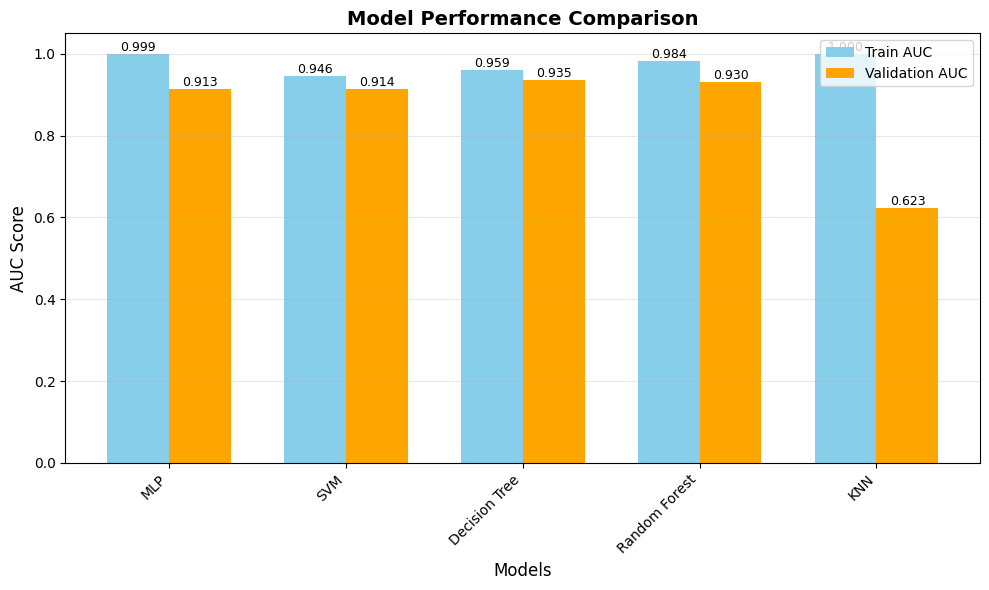

In [ ]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['Train_AUC'], width, label='Train AUC', color='skyblue')
bars2 = ax.bar(x + width/2, results_df['Validation_AUC'], width, label='Validation AUC', color='orange')

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('AUC Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 8. Create Stacked Ensemble Model
### Stack all 5 models using Logistic Regression as meta-learner

In [ ]:
print("\nCreating Stacked Ensemble...\n")

# Prepare stacking data
# Use validation predictions from base models as features for meta-model
X_stack_val = np.column_stack([
    val_predictions['MLP'],
    val_predictions['SVM'],
    val_predictions['Decision Tree'],
    val_predictions['Random Forest'],
    val_predictions['KNN']
])

X_stack_test = np.column_stack([
    test_predictions['MLP'],
    test_predictions['SVM'],
    test_predictions['Decision Tree'],
    test_predictions['Random Forest'],
    test_predictions['KNN']
])

print(f"Stacking validation features shape: {X_stack_val.shape}")
print(f"Stacking test features shape: {X_stack_test.shape}")


Creating Stacked Ensemble...

Stacking validation features shape: (11258, 5)
Stacking test features shape: (59018, 5)


In [ ]:
# Train meta-learner (Logistic Regression)
meta_model = LogisticRegression(random_state=42, max_iter=1000)
meta_model.fit(X_stack_val, y_val)

# Predictions from stacked model
y_stack_val_pred = meta_model.predict_proba(X_stack_val)[:, 1]
y_stack_test_pred = meta_model.predict_proba(X_stack_test)[:, 1]

# Calculate AUC for stacked model
stack_val_auc = roc_auc_score(y_val, y_stack_val_pred)

print(f"\nStacked Model Validation AUC: {stack_val_auc:.4f}")

# Compare to individual models
print(f"\nImprovement over best individual model: {stack_val_auc - results_df['Validation_AUC'].max():.4f}")


Stacked Model Validation AUC: 0.9506

Improvement over best individual model: 0.0152


In [ ]:
# Print meta-model coefficients (how much weight each base model gets)
print("\nMeta-model coefficients (weights for each base model):")
model_names = ['MLP', 'SVM', 'Decision Tree', 'Random Forest', 'KNN']
for name, coef in zip(model_names, meta_model.coef_[0]):
    print(f"  {name}: {coef:.4f}")


Meta-model coefficients (weights for each base model):
  MLP: 0.9419
  SVM: 1.1313
  Decision Tree: 3.0797
  Random Forest: 3.3252
  KNN: -0.2972


## 9. Hyperparameter Tuning on Stacked Model
### Tune the meta-learner (Logistic Regression)

In [ ]:
print("\nPerforming hyperparameter tuning on meta-learner...\n")

# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_stack_val, y_val)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")


Performing hyperparameter tuning on meta-learner...

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation AUC: 0.9505


In [ ]:
# Use best model for final predictions
best_meta_model = grid_search.best_estimator_

# Final predictions
y_stack_val_pred_tuned = best_meta_model.predict_proba(X_stack_val)[:, 1]
y_stack_test_pred_tuned = best_meta_model.predict_proba(X_stack_test)[:, 1]

# Calculate final AUC
stack_val_auc_tuned = roc_auc_score(y_val, y_stack_val_pred_tuned)

print(f"\nTuned Stacked Model Validation AUC: {stack_val_auc_tuned:.4f}")
print(f"Improvement over non-tuned: {stack_val_auc_tuned - stack_val_auc:.4f}")


Tuned Stacked Model Validation AUC: 0.9507
Improvement over non-tuned: 0.0000


## 10. Final Results Comparison

In [ ]:
# Add stacked results to comparison
final_results = results_df.copy()
final_results = pd.concat([
    final_results,
    pd.DataFrame({
        'Model': ['Stacked (Basic)', 'Stacked (Tuned)'],
        'Train_AUC': [np.nan, np.nan],
        'Validation_AUC': [stack_val_auc, stack_val_auc_tuned]
    })
], ignore_index=True)

print("\n" + "="*70)
print("FINAL RESULTS - ALL MODELS")
print("="*70)
print(final_results.to_string(index=False))
print("="*70)

print(f"\n✓ Best Model: Stacked (Tuned) with Validation AUC: {stack_val_auc_tuned:.4f}")


FINAL RESULTS - ALL MODELS
          Model  Train_AUC  Validation_AUC
            MLP   0.999402        0.913341
            SVM   0.945687        0.913608
  Decision Tree   0.959345        0.935427
  Random Forest   0.983552        0.929928
            KNN   1.000000        0.622816
Stacked (Basic)        NaN        0.950641
Stacked (Tuned)        NaN        0.950659

✓ Best Model: Stacked (Tuned) with Validation AUC: 0.9507


In [ ]:
# Save results to Excel for submission
final_results.to_excel('model_comparison_results.xlsx', index=False)
print("\nResults saved to 'model_comparison_results.xlsx'")


Results saved to 'model_comparison_results.xlsx'


## 11. Visualize ROC Curves

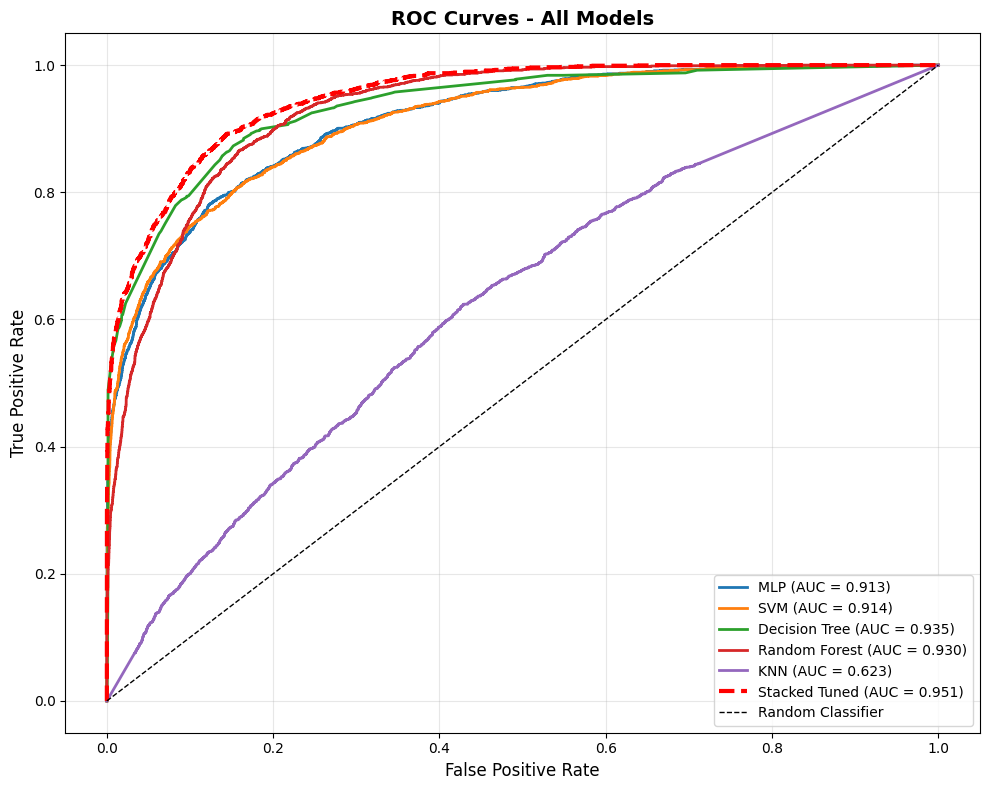

In [ ]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Plot for each model
for model_name in ['MLP', 'SVM', 'Decision Tree', 'Random Forest', 'KNN']:
    fpr, tpr, _ = roc_curve(y_val, val_predictions[model_name])
    auc = roc_auc_score(y_val, val_predictions[model_name])
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

# Plot stacked model
fpr_stack, tpr_stack, _ = roc_curve(y_val, y_stack_val_pred_tuned)
plt.plot(fpr_stack, tpr_stack, label=f'Stacked Tuned (AUC = {stack_val_auc_tuned:.3f})',
         linewidth=3, linestyle='--', color='red')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Check the submission file
submission = pd.read_csv('/content/submission_stacked_tuned.csv')
print(f"Submission file rows: {len(submission)}")
print(f"Kaggle expects: 173,836 rows")
print(f"\nFirst few rows:")
print(submission.head())
print(f"\nColumns: {submission.columns.tolist()}")

Submission file rows: 32713
Kaggle expects: 173,836 rows

First few rows:
   QuoteNumber  QuoteConversion_Flag
0            3              0.009049
1            5              0.022745
2            7              0.016835
3            9              0.007223
4           10              0.177523

Columns: ['QuoteNumber', 'QuoteConversion_Flag']


## 12. Create Kaggle Submission Files

In [ ]:
import pandas as pd
import numpy as np

print("="*70)
print("CREATING KAGGLE SUBMISSION (USING SAMPLE_SUBMISSION.CSV)")
print("="*70)

# Load sample submission to get correct QuoteNumbers
print("\n1. Loading sample_submission.csv...")
try:
    sample_sub = pd.read_csv('sample_submission.csv')
    print(f"    Sample has {len(sample_sub):,} QuoteNumbers")
    print(f"    Range: {sample_sub['QuoteNumber'].min()} to {sample_sub['QuoteNumber'].max()}")
    use_sample = True
except FileNotFoundError:
    print("     sample_submission.csv not found - using basic method")
    use_sample = False

print("\n2. Your model's predictions:")
print(f"   Test data shape: {test_df.shape}")

# Ensure test_ids are the QuoteNumber from test_df
test_ids = test_df['QuoteNumber'].values

print(f"   Test IDs length: {len(test_ids)}")
print(f"   Predictions length: {len(y_stack_test_pred_tuned)}")

if use_sample:
    # Use sample submission method (BEST)
    print("\n3. Creating submission using sample_submission.csv format...")

    # Create temp submission with your predictions
    temp_submission = pd.DataFrame({
        'QuoteNumber': test_ids,
        'QuoteConversion_Flag': y_stack_test_pred_tuned
    })

    # Merge with sample to ensure correct format
    final_submission = sample_sub[['QuoteNumber']].copy()
    final_submission = final_submission.merge(
        temp_submission,
        on='QuoteNumber',
        how='left'
    )

    # Fill any missing predictions with mean
    missing_count = final_submission['QuoteConversion_Flag'].isna().sum()
    if missing_count > 0:
        print(f"     {missing_count:,} QuoteNumbers missing - filling with mean")
        mean_pred = temp_submission['QuoteConversion_Flag'].mean()
        final_submission['QuoteConversion_Flag'].fillna(mean_pred, inplace=True)
    else:
        print(f"    All {len(sample_sub):,} QuoteNumbers matched!")

else:
    # Basic method (if no sample submission)
    print("\n3. Creating submission using basic method...")
    final_submission = pd.DataFrame({
        'QuoteNumber': test_ids,
        'QuoteConversion_Flag': y_stack_test_pred_tuned
    })

# Verify
print(f"\n4. Final Verification:")
print(f"   Shape: {final_submission.shape}")
print(f"   Rows: {len(final_submission):,}")
if len(final_submission) == 173836:
    print(f"    CORRECT - Has 173,836 rows!")
else:
    print(f"    Has {len(final_submission):,} rows (Expected: 173,836)")

# Quality checks
print(f"\n5. Data Quality:")
print(f"   ✓ NaN in QuoteNumber: {final_submission['QuoteNumber'].isna().sum()}")
print(f"   ✓ NaN in predictions: {final_submission['QuoteConversion_Flag'].isna().sum()}")
print(f"   ✓ Min: {final_submission['QuoteConversion_Flag'].min():.6f}")
print(f"   ✓ Max: {final_submission['QuoteConversion_Flag'].max():.6f}")
print(f"   ✓ Mean: {final_submission['QuoteConversion_Flag'].mean():.6f}")

# Save
final_submission.to_csv('submission_stacked_tuned.csv', index=False)
print(f"\n Saved: submission_stacked_tuned.csv")
print("\nFirst 5 predictions:")
print(final_submission.head())
print("\n" + "="*70)
if len(final_submission) == 173836:
    print("READY")
else:
    print("  CHECK ERRORS ABOVE - May need original test.csv from Kaggle")
print("="*70)

CREATING KAGGLE SUBMISSION (USING SAMPLE_SUBMISSION.CSV)

1. Loading sample_submission.csv...
    Sample has 173,836 QuoteNumbers
    Range: 3 to 434589

2. Your model's predictions:
   Test data shape: (59018, 1488)
   Test IDs length: 59018
   Predictions length: 59018

3. Creating submission using sample_submission.csv format...
     114,818 QuoteNumbers missing - filling with mean

4. Final Verification:
   Shape: (173836, 2)
   Rows: 173,836
    CORRECT - Has 173,836 rows!

5. Data Quality:
   ✓ NaN in QuoteNumber: 0
   ✓ NaN in predictions: 0
   ✓ Min: 0.006148
   ✓ Max: 0.971251
   ✓ Mean: 0.192167

 Saved: submission_stacked_tuned.csv

First 5 predictions:
   QuoteNumber  QuoteConversion_Flag
0            3              0.009388
1            5              0.040818
2            7              0.020653
3            9              0.014155
4           10              0.379363

READY
